In [23]:
from greensight.utils import DIR_ROOT, DIR_DATA
import pandas as pd
import numpy as np
from datetime import datetime
import json
from typing import Union
from pathlib import Path
import re
from tqdm.notebook import tqdm

In [3]:
sentinel_data_path = DIR_DATA / "sentinel_data"
assert sentinel_data_path.is_dir()

In [4]:
year_paths = [path for path in sorted(list(sentinel_data_path.iterdir())) if "2016" not in path.name]

In [14]:

def load_sentinel_two_data_from_csv(path: Union[str, Path]) -> pd.DataFrame:

    """""
    loads sentinel two data from file path and process into dataframe 
    """
    from greensight.indices import INDEX_NAMES

    path = Path(path)
    assert path.is_file()

    # Extract the year using regex
    match = re.search(r"\d{4}", str(path))
    year = int(match.group(0) if match else None)

    df = pd.read_csv(path)

    # drop unwanted columns
    df = df.drop(columns=["system:index", ".geo"])

    # check columns (month_band) for duplicates
    assert np.unique(df.columns).shape == df.columns.shape

    # get unique band identifiers
    band_inds = list(set(
        sorted([i.split("_")[1] for i in df.columns.unique() if i.split("_")[0].isnumeric()])
    ))

    # get month identifiers
    month_inds = set(
        [i.split("_")[0] for i in df.columns.unique() if i.split("_")[0].isnumeric()]
    )

    # set index
    df = df.set_index("LAD_CD")

    months = []
    inds = []
    for month in month_inds:
        # generate desired columns
        cols = [month + "_" + band for band in band_inds]
        print(cols)

        # create df of desired columns
        df_month = df[cols].copy()

        # convert from a DataFrame of rows: shapes, columns: bands for a single month to a single row of rows: month, columns: (shape, band)
        row_month = df_month.stack().to_frame().T

        # create multi-index for the columns (shape, band)
        new_cols = [(a, b.split("_")[1]) for a, b in row_month.columns]
        row_month.columns = pd.MultiIndex.from_tuples(new_cols)

        # add to stack
        months.append(row_month)
        # add month name to index.
        inds.append(month)


    # combine rows
    df_month = pd.concat(months, axis=0)

    # fix index to month value
    df_month.index = np.array(inds).astype(int) + 1

    # format index
    df_month = df_month.sort_index()
    df_month.index.name = "date"
    df_month.index = [datetime(year, int(month), 1) for month in df_month.index]
    df_month.columns.names = ("shape", "band")

    assert df_month.shape == (len(month_inds), len(band_inds)*df.shape[0])

    # add greenbelt information from json dict.
    lookup_path = DIR_ROOT / "resources/id_lookup/id_lookup.json"
    with open(lookup_path, "r") as in_file:
        D_lookup = json.load(in_file)
    greenbelts = [D_lookup[code]["GB_Name"] for code, _ in df_month.columns]

    # add greenbelts to column MultiIndex
    df_month.columns = pd.MultiIndex.from_tuples(
        [(gb, *cols) for gb, cols in zip(greenbelts, df_month.columns)]
    )
    df_month.columns.names = ("greenbelt", "shape", "band")

    return df_month

In [15]:
df_all = []
for year_path in tqdm(year_paths):
    year_files = [file for file in year_path.iterdir() if "mean" in file.stem and "S2" in file.stem]

    df_year = []
    for file in tqdm(year_files):
        out = load_sentinel_two_data_from_csv(file)
        df_year.append(out)
    df_year = pd.concat(df_year, axis=1)
    
    df_all.append(df_year)


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

['11_B12', '11_B3', '11_B11', '11_B2', '11_B9', '11_B8A', '11_B5', '11_B8', '11_B1', '11_B7', '11_B6', '11_B4']
['4_B12', '4_B3', '4_B11', '4_B2', '4_B9', '4_B8A', '4_B5', '4_B8', '4_B1', '4_B7', '4_B6', '4_B4']
['9_B12', '9_B3', '9_B11', '9_B2', '9_B9', '9_B8A', '9_B5', '9_B8', '9_B1', '9_B7', '9_B6', '9_B4']
['5_B12', '5_B3', '5_B11', '5_B2', '5_B9', '5_B8A', '5_B5', '5_B8', '5_B1', '5_B7', '5_B6', '5_B4']
['10_B12', '10_B3', '10_B11', '10_B2', '10_B9', '10_B8A', '10_B5', '10_B8', '10_B1', '10_B7', '10_B6', '10_B4']
['6_B12', '6_B3', '6_B11', '6_B2', '6_B9', '6_B8A', '6_B5', '6_B8', '6_B1', '6_B7', '6_B6', '6_B4']
['3_B12', '3_B3', '3_B11', '3_B2', '3_B9', '3_B8A', '3_B5', '3_B8', '3_B1', '3_B7', '3_B6', '3_B4']
['8_B12', '8_B3', '8_B11', '8_B2', '8_B9', '8_B8A', '8_B5', '8_B8', '8_B1', '8_B7', '8_B6', '8_B4']
['11_B12', '11_B3', '11_B11', '11_B2', '11_B9', '11_B8A', '11_B5', '11_B8', '11_B1', '11_B7', '11_B6', '11_B4']
['4_B12', '4_B3', '4_B11', '4_B2', '4_B9', '4_B8A', '4_B5', '4_B

  0%|          | 0/10 [00:00<?, ?it/s]

['1_B12', '1_B3', '1_B11', '1_B2', '1_B9', '1_B8A', '1_B5', '1_B8', '1_B1', '1_B7', '1_B6', '1_B4']
['11_B12', '11_B3', '11_B11', '11_B2', '11_B9', '11_B8A', '11_B5', '11_B8', '11_B1', '11_B7', '11_B6', '11_B4']
['4_B12', '4_B3', '4_B11', '4_B2', '4_B9', '4_B8A', '4_B5', '4_B8', '4_B1', '4_B7', '4_B6', '4_B4']
['7_B12', '7_B3', '7_B11', '7_B2', '7_B9', '7_B8A', '7_B5', '7_B8', '7_B1', '7_B7', '7_B6', '7_B4']
['9_B12', '9_B3', '9_B11', '9_B2', '9_B9', '9_B8A', '9_B5', '9_B8', '9_B1', '9_B7', '9_B6', '9_B4']
['5_B12', '5_B3', '5_B11', '5_B2', '5_B9', '5_B8A', '5_B5', '5_B8', '5_B1', '5_B7', '5_B6', '5_B4']
['10_B12', '10_B3', '10_B11', '10_B2', '10_B9', '10_B8A', '10_B5', '10_B8', '10_B1', '10_B7', '10_B6', '10_B4']
['6_B12', '6_B3', '6_B11', '6_B2', '6_B9', '6_B8A', '6_B5', '6_B8', '6_B1', '6_B7', '6_B6', '6_B4']
['3_B12', '3_B3', '3_B11', '3_B2', '3_B9', '3_B8A', '3_B5', '3_B8', '3_B1', '3_B7', '3_B6', '3_B4']
['8_B12', '8_B3', '8_B11', '8_B2', '8_B9', '8_B8A', '8_B5', '8_B8', '8_B1', 

  0%|          | 0/10 [00:00<?, ?it/s]

['1_B12', '1_B3', '1_B11', '1_B2', '1_B9', '1_B8A', '1_B5', '1_B8', '1_B1', '1_B7', '1_B6', '1_B4']
['11_B12', '11_B3', '11_B11', '11_B2', '11_B9', '11_B8A', '11_B5', '11_B8', '11_B1', '11_B7', '11_B6', '11_B4']
['4_B12', '4_B3', '4_B11', '4_B2', '4_B9', '4_B8A', '4_B5', '4_B8', '4_B1', '4_B7', '4_B6', '4_B4']
['7_B12', '7_B3', '7_B11', '7_B2', '7_B9', '7_B8A', '7_B5', '7_B8', '7_B1', '7_B7', '7_B6', '7_B4']
['9_B12', '9_B3', '9_B11', '9_B2', '9_B9', '9_B8A', '9_B5', '9_B8', '9_B1', '9_B7', '9_B6', '9_B4']
['5_B12', '5_B3', '5_B11', '5_B2', '5_B9', '5_B8A', '5_B5', '5_B8', '5_B1', '5_B7', '5_B6', '5_B4']
['10_B12', '10_B3', '10_B11', '10_B2', '10_B9', '10_B8A', '10_B5', '10_B8', '10_B1', '10_B7', '10_B6', '10_B4']
['6_B12', '6_B3', '6_B11', '6_B2', '6_B9', '6_B8A', '6_B5', '6_B8', '6_B1', '6_B7', '6_B6', '6_B4']
['3_B12', '3_B3', '3_B11', '3_B2', '3_B9', '3_B8A', '3_B5', '3_B8', '3_B1', '3_B7', '3_B6', '3_B4']
['8_B12', '8_B3', '8_B11', '8_B2', '8_B9', '8_B8A', '8_B5', '8_B8', '8_B1', 

  0%|          | 0/10 [00:00<?, ?it/s]

['1_B12', '1_B3', '1_B11', '1_B2', '1_B9', '1_B8A', '1_B5', '1_B8', '1_B1', '1_B7', '1_B6', '1_B4']
['11_B12', '11_B3', '11_B11', '11_B2', '11_B9', '11_B8A', '11_B5', '11_B8', '11_B1', '11_B7', '11_B6', '11_B4']
['4_B12', '4_B3', '4_B11', '4_B2', '4_B9', '4_B8A', '4_B5', '4_B8', '4_B1', '4_B7', '4_B6', '4_B4']
['7_B12', '7_B3', '7_B11', '7_B2', '7_B9', '7_B8A', '7_B5', '7_B8', '7_B1', '7_B7', '7_B6', '7_B4']
['9_B12', '9_B3', '9_B11', '9_B2', '9_B9', '9_B8A', '9_B5', '9_B8', '9_B1', '9_B7', '9_B6', '9_B4']
['5_B12', '5_B3', '5_B11', '5_B2', '5_B9', '5_B8A', '5_B5', '5_B8', '5_B1', '5_B7', '5_B6', '5_B4']
['10_B12', '10_B3', '10_B11', '10_B2', '10_B9', '10_B8A', '10_B5', '10_B8', '10_B1', '10_B7', '10_B6', '10_B4']
['6_B12', '6_B3', '6_B11', '6_B2', '6_B9', '6_B8A', '6_B5', '6_B8', '6_B1', '6_B7', '6_B6', '6_B4']
['3_B12', '3_B3', '3_B11', '3_B2', '3_B9', '3_B8A', '3_B5', '3_B8', '3_B1', '3_B7', '3_B6', '3_B4']
['8_B12', '8_B3', '8_B11', '8_B2', '8_B9', '8_B8A', '8_B5', '8_B8', '8_B1', 

  0%|          | 0/11 [00:00<?, ?it/s]

['1_B12', '1_B3', '1_B11', '1_B2', '1_B9', '1_B8A', '1_B5', '1_B8', '1_B1', '1_B7', '1_B6', '1_B4']
['11_B12', '11_B3', '11_B11', '11_B2', '11_B9', '11_B8A', '11_B5', '11_B8', '11_B1', '11_B7', '11_B6', '11_B4']
['4_B12', '4_B3', '4_B11', '4_B2', '4_B9', '4_B8A', '4_B5', '4_B8', '4_B1', '4_B7', '4_B6', '4_B4']
['7_B12', '7_B3', '7_B11', '7_B2', '7_B9', '7_B8A', '7_B5', '7_B8', '7_B1', '7_B7', '7_B6', '7_B4']
['9_B12', '9_B3', '9_B11', '9_B2', '9_B9', '9_B8A', '9_B5', '9_B8', '9_B1', '9_B7', '9_B6', '9_B4']
['5_B12', '5_B3', '5_B11', '5_B2', '5_B9', '5_B8A', '5_B5', '5_B8', '5_B1', '5_B7', '5_B6', '5_B4']
['10_B12', '10_B3', '10_B11', '10_B2', '10_B9', '10_B8A', '10_B5', '10_B8', '10_B1', '10_B7', '10_B6', '10_B4']
['6_B12', '6_B3', '6_B11', '6_B2', '6_B9', '6_B8A', '6_B5', '6_B8', '6_B1', '6_B7', '6_B6', '6_B4']
['3_B12', '3_B3', '3_B11', '3_B2', '3_B9', '3_B8A', '3_B5', '3_B8', '3_B1', '3_B7', '3_B6', '3_B4']
['8_B12', '8_B3', '8_B11', '8_B2', '8_B9', '8_B8A', '8_B5', '8_B8', '8_B1', 

  0%|          | 0/10 [00:00<?, ?it/s]

['1_B12', '1_B3', '1_B11', '1_B2', '1_B9', '1_B8A', '1_B5', '1_B8', '1_B1', '1_B7', '1_B6', '1_B4']
['11_B12', '11_B3', '11_B11', '11_B2', '11_B9', '11_B8A', '11_B5', '11_B8', '11_B1', '11_B7', '11_B6', '11_B4']
['4_B12', '4_B3', '4_B11', '4_B2', '4_B9', '4_B8A', '4_B5', '4_B8', '4_B1', '4_B7', '4_B6', '4_B4']
['7_B12', '7_B3', '7_B11', '7_B2', '7_B9', '7_B8A', '7_B5', '7_B8', '7_B1', '7_B7', '7_B6', '7_B4']
['9_B12', '9_B3', '9_B11', '9_B2', '9_B9', '9_B8A', '9_B5', '9_B8', '9_B1', '9_B7', '9_B6', '9_B4']
['5_B12', '5_B3', '5_B11', '5_B2', '5_B9', '5_B8A', '5_B5', '5_B8', '5_B1', '5_B7', '5_B6', '5_B4']
['10_B12', '10_B3', '10_B11', '10_B2', '10_B9', '10_B8A', '10_B5', '10_B8', '10_B1', '10_B7', '10_B6', '10_B4']
['6_B12', '6_B3', '6_B11', '6_B2', '6_B9', '6_B8A', '6_B5', '6_B8', '6_B1', '6_B7', '6_B6', '6_B4']
['3_B12', '3_B3', '3_B11', '3_B2', '3_B9', '3_B8A', '3_B5', '3_B8', '3_B1', '3_B7', '3_B6', '3_B4']
['8_B12', '8_B3', '8_B11', '8_B2', '8_B9', '8_B8A', '8_B5', '8_B8', '8_B1', 

  0%|          | 0/10 [00:00<?, ?it/s]

['1_B12', '1_B3', '1_B11', '1_B2', '1_B9', '1_B8A', '1_B5', '1_B8', '1_B1', '1_B7', '1_B6', '1_B4']
['11_B12', '11_B3', '11_B11', '11_B2', '11_B9', '11_B8A', '11_B5', '11_B8', '11_B1', '11_B7', '11_B6', '11_B4']
['4_B12', '4_B3', '4_B11', '4_B2', '4_B9', '4_B8A', '4_B5', '4_B8', '4_B1', '4_B7', '4_B6', '4_B4']
['7_B12', '7_B3', '7_B11', '7_B2', '7_B9', '7_B8A', '7_B5', '7_B8', '7_B1', '7_B7', '7_B6', '7_B4']
['9_B12', '9_B3', '9_B11', '9_B2', '9_B9', '9_B8A', '9_B5', '9_B8', '9_B1', '9_B7', '9_B6', '9_B4']
['5_B12', '5_B3', '5_B11', '5_B2', '5_B9', '5_B8A', '5_B5', '5_B8', '5_B1', '5_B7', '5_B6', '5_B4']
['10_B12', '10_B3', '10_B11', '10_B2', '10_B9', '10_B8A', '10_B5', '10_B8', '10_B1', '10_B7', '10_B6', '10_B4']
['6_B12', '6_B3', '6_B11', '6_B2', '6_B9', '6_B8A', '6_B5', '6_B8', '6_B1', '6_B7', '6_B6', '6_B4']
['3_B12', '3_B3', '3_B11', '3_B2', '3_B9', '3_B8A', '3_B5', '3_B8', '3_B1', '3_B7', '3_B6', '3_B4']
['8_B12', '8_B3', '8_B11', '8_B2', '8_B9', '8_B8A', '8_B5', '8_B8', '8_B1', 

  0%|          | 0/10 [00:00<?, ?it/s]

['4_B12', '4_B3', '4_B11', '4_B2', '4_B9', '4_B8A', '4_B5', '4_B8', '4_B1', '4_B7', '4_B6', '4_B4']
['7_B12', '7_B3', '7_B11', '7_B2', '7_B9', '7_B8A', '7_B5', '7_B8', '7_B1', '7_B7', '7_B6', '7_B4']
['9_B12', '9_B3', '9_B11', '9_B2', '9_B9', '9_B8A', '9_B5', '9_B8', '9_B1', '9_B7', '9_B6', '9_B4']
['5_B12', '5_B3', '5_B11', '5_B2', '5_B9', '5_B8A', '5_B5', '5_B8', '5_B1', '5_B7', '5_B6', '5_B4']
['6_B12', '6_B3', '6_B11', '6_B2', '6_B9', '6_B8A', '6_B5', '6_B8', '6_B1', '6_B7', '6_B6', '6_B4']
['3_B12', '3_B3', '3_B11', '3_B2', '3_B9', '3_B8A', '3_B5', '3_B8', '3_B1', '3_B7', '3_B6', '3_B4']
['8_B12', '8_B3', '8_B11', '8_B2', '8_B9', '8_B8A', '8_B5', '8_B8', '8_B1', '8_B7', '8_B6', '8_B4']
['2_B12', '2_B3', '2_B11', '2_B2', '2_B9', '2_B8A', '2_B5', '2_B8', '2_B1', '2_B7', '2_B6', '2_B4']
['0_B12', '0_B3', '0_B11', '0_B2', '0_B9', '0_B8A', '0_B5', '0_B8', '0_B1', '0_B7', '0_B6', '0_B4']
['4_B12', '4_B3', '4_B11', '4_B2', '4_B9', '4_B8A', '4_B5', '4_B8', '4_B1', '4_B7', '4_B6', '4_B4']


In [17]:
# remove additional columns
df_all2 = [df[df_all[0].columns] for df in df_all]

In [18]:
# remove duplicate columns
df_all_combined = []

for df in df_all2:
    unique_columns = ~df.columns.duplicated(keep='first')

    df_unique = df.loc[:, unique_columns]

    df_all_combined.append(df_unique)

In [19]:
for df in df_all_combined:
    print(df.shape)

(9, 2160)
(12, 2160)
(12, 2160)
(12, 2160)
(12, 2160)
(12, 2160)
(12, 2160)
(10, 2160)


In [20]:
df_out = pd.concat(df_all_combined, axis=0)

In [21]:
df_out.head()

greenbelt  Bath and Bristol                                                    \
shape             E06000022                                                     
band                    B12          B3          B11          B2           B9   
2017-04-01      1020.251965  623.238776  1894.865456  311.276690  4068.776515   
2017-05-01       991.962320  635.020438  1909.530406  302.160542  4384.997329   
2017-06-01      1161.614115  724.435485  2188.810410  340.702544  4549.696552   
2017-07-01      1048.994736  677.887598  2017.795291  363.510906  4043.190219   
2017-08-01              NaN         NaN          NaN         NaN          NaN   

greenbelt                                                                   \
shape                                                                        
band                B8A           B5           B8          B1           B7   
2017-04-01  4035.477838  1094.207824  3999.326764  234.805820  3732.298612   
2017-05-01  4353.982110  1125.957264  4197.780260  216.930759  4058.373258   
2017-06-01  4480.317738  1301.592959  4226.873012  252.662771  4113.497425   
2017-07-01  3993.286431  1183.826676  3856.484979  300.029123  3686.713608   
2017-08-01          NaN          NaN          NaN         NaN          NaN   

greenbelt   ...         York                                        \
shape       ...    E07000167                                         
band        ...          B11          B2           B9          B8A   
2017-04-01  ...          NaN         NaN          NaN          NaN   
2017-05-01  ...  1819.617433  343.276927  3575.736009  3544.669321   
2017-06-01  ...          NaN         NaN          NaN          NaN   
2017-07-01  ...          NaN         NaN          NaN          NaN   
2017-08-01  ...          NaN         NaN          NaN          NaN   

greenbelt                                                                  \
shape                                                                       
band                 B5           B8          B1           B7          B6   
2017-04-01          NaN          NaN         NaN          NaN         NaN   
2017-05-01  1045.571895  3509.033587  249.211902  3335.098446  2744.18825   
2017-06-01          NaN          NaN         NaN          NaN         NaN   
2017-07-01          NaN          NaN         NaN          NaN         NaN   
2017-08-01          NaN          NaN         NaN          NaN         NaN   

greenbelt               
shape                   
band                B4  
2017-04-01         NaN  
2017-05-01  507.285913  
2017-06-01         NaN  
2017-07-01         NaN  
2017-08-01         NaN  

[5 rows x 2160 columns]

In [26]:
df_out["Burton-upon-Trent and Swadlincote"]

shape         E07000193                                                    \
band                B12          B3          B11          B2           B9   
2017-04-01  1577.503407  842.215883  2098.731887  537.550697  3599.195434   
2017-05-01  1419.721732  900.043414  2177.062888  578.206745  3961.154544   
2017-06-01          NaN         NaN          NaN         NaN          NaN   
2017-07-01          NaN         NaN          NaN         NaN          NaN   
2017-08-01   633.324392  638.389200  1334.924351  378.916222  3135.832153   
...                 ...         ...          ...         ...          ...   
2024-06-01  1410.201427  774.165368  1856.188584  485.743123  3388.511921   
2024-07-01  1228.614930  740.026938  2069.071663  424.807395  3809.079390   
2024-08-01  1018.655460  703.363499  1876.475467  449.655910  3898.755093   
2024-09-01  1152.801689  744.940594  1994.080769  519.513694  3494.357999   
2024-10-01   651.269252  566.588916  1008.649275  440.401106  1540.935241   

shape                                                                       \
band                B8A           B5           B8          B1           B7   
2017-04-01  3651.462392  1439.948137  3697.130544  527.769908  3468.527486   
2017-05-01  4101.055404  1461.749292  4161.701142  400.916807  3879.821637   
2017-06-01          NaN          NaN          NaN         NaN          NaN   
2017-07-01          NaN          NaN          NaN         NaN          NaN   
2017-08-01  3126.175247   972.223606  3047.511385  124.006596  2972.050872   
...                 ...          ...          ...         ...          ...   
2024-06-01  3414.127214  1264.667947  3453.185757  367.365819  3226.026941   
2024-07-01  3905.907450  1205.834637  3748.980424  334.075038  3700.795413   
2024-08-01  3992.714510  1085.683453  3828.150520  358.904013  3727.597994   
2024-09-01  3572.379222  1094.015522  3546.630962  419.169028  3339.859821   
2024-10-01  1681.505024   790.575921  1682.096886  413.903780  1585.724655   

shape                                
band                 B6          B4  
2017-04-01  2904.222358  933.910222  
2017-05-01  3279.300184  844.237270  
2017-06-01          NaN         NaN  
2017-07-01          NaN         NaN  
2017-08-01  2578.320409  426.654378  
...                 ...         ...  
2024-06-01  2692.033865  747.275229  
2024-07-01  3061.900513  556.618000  
2024-08-01  2959.296365  510.723553  
2024-09-01  2734.267695  592.956184  
2024-10-01  1412.229555  531.495543  

[91 rows x 12 columns]

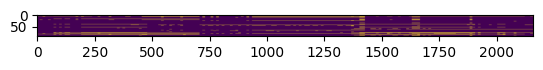

In [22]:
import matplotlib.pyplot as plt
plt.imshow(df_out.isna())

In [28]:
# clean up greenbelt place names
df_out.columns = pd.MultiIndex.from_tuples([(i[0].replace("-", " ").replace(",", "") , i[1], i[2]) for i in df_out.columns])
df_out.columns.names = ["greenbelt", "shape", "band"]
df_out.head()

greenbelt  Bath and Bristol                                                    \
shape             E06000022                                                     
band                    B12          B3          B11          B2           B9   
2017-04-01      1020.251965  623.238776  1894.865456  311.276690  4068.776515   
2017-05-01       991.962320  635.020438  1909.530406  302.160542  4384.997329   
2017-06-01      1161.614115  724.435485  2188.810410  340.702544  4549.696552   
2017-07-01      1048.994736  677.887598  2017.795291  363.510906  4043.190219   
2017-08-01              NaN         NaN          NaN         NaN          NaN   

greenbelt                                                                   \
shape                                                                        
band                B8A           B5           B8          B1           B7   
2017-04-01  4035.477838  1094.207824  3999.326764  234.805820  3732.298612   
2017-05-01  4353.982110  1125.957264  4197.780260  216.930759  4058.373258   
2017-06-01  4480.317738  1301.592959  4226.873012  252.662771  4113.497425   
2017-07-01  3993.286431  1183.826676  3856.484979  300.029123  3686.713608   
2017-08-01          NaN          NaN          NaN         NaN          NaN   

greenbelt   ...         York                                        \
shape       ...    E07000167                                         
band        ...          B11          B2           B9          B8A   
2017-04-01  ...          NaN         NaN          NaN          NaN   
2017-05-01  ...  1819.617433  343.276927  3575.736009  3544.669321   
2017-06-01  ...          NaN         NaN          NaN          NaN   
2017-07-01  ...          NaN         NaN          NaN          NaN   
2017-08-01  ...          NaN         NaN          NaN          NaN   

greenbelt                                                                  \
shape                                                                       
band                 B5           B8          B1           B7          B6   
2017-04-01          NaN          NaN         NaN          NaN         NaN   
2017-05-01  1045.571895  3509.033587  249.211902  3335.098446  2744.18825   
2017-06-01          NaN          NaN         NaN          NaN         NaN   
2017-07-01          NaN          NaN         NaN          NaN         NaN   
2017-08-01          NaN          NaN         NaN          NaN         NaN   

greenbelt               
shape                   
band                B4  
2017-04-01         NaN  
2017-05-01  507.285913  
2017-06-01         NaN  
2017-07-01         NaN  
2017-08-01         NaN  

[5 rows x 2160 columns]

In [29]:
# save DataFrame
output_path = DIR_DATA / "processed_data/sentinel_two_df.hdf"
df_out.to_hdf(output_path, key="df", mode="w", format="table")

In [34]:
df_out["Carnforth Lancaster and Morecambe"]


shape         E07000121                                                    \
band                B12          B3          B11          B2           B9   
2017-04-01   981.716510  595.720956  1936.909815  346.779029  4057.732595   
2017-05-01  1081.477479  623.888394  2140.396810  281.707684  4725.015300   
2017-06-01          NaN         NaN          NaN         NaN          NaN   
2017-07-01          NaN         NaN          NaN         NaN          NaN   
2017-08-01   975.595316  606.400487  1984.830491  245.606523  4350.535717   
...                 ...         ...          ...         ...          ...   
2024-06-01  1273.573667  869.640930  2270.991051  552.363363  4672.895724   
2024-07-01          NaN         NaN          NaN         NaN          NaN   
2024-08-01  1102.132554  738.968604  2165.867494  419.742013  4650.404786   
2024-09-01  1034.963350  640.167349  2045.682526  311.075374  4322.094998   
2024-10-01  1041.880555  641.683769  2030.017591  337.005196  4035.339620   

shape                                                                       \
band                B8A           B5           B8          B1           B7   
2017-04-01  4011.054954  1022.338159  4002.631184  356.149619  3711.681426   
2017-05-01  4672.083196  1171.021479  4589.434406  233.597934  4295.796740   
2017-06-01          NaN          NaN          NaN         NaN          NaN   
2017-07-01          NaN          NaN          NaN         NaN          NaN   
2017-08-01  4330.655843  1118.181154  4173.458505  135.684205  4004.900130   
...                 ...          ...          ...         ...          ...   
2024-06-01  4700.858831  1400.261779  4585.616902  488.991842  4356.268902   
2024-07-01          NaN          NaN          NaN         NaN          NaN   
2024-08-01  4595.227861  1212.259334  4509.972087  339.750299  4247.876394   
2024-09-01  4252.643045  1133.967763  4147.335732  244.259348  3906.727664   
2024-10-01  4019.018801  1104.585287  3940.644636  260.178785  3675.550310   

shape                                
band                 B6          B4  
2017-04-01  3045.232730  356.734276  
2017-05-01  3480.774802  380.873033  
2017-06-01          NaN         NaN  
2017-07-01          NaN         NaN  
2017-08-01  3303.923925  350.446525  
...                 ...         ...  
2024-06-01  3533.654966  609.299096  
2024-07-01          NaN         NaN  
2024-08-01  3454.372028  439.097023  
2024-09-01  3212.270346  380.806930  
2024-10-01  3060.992466  392.258228  

[91 rows x 12 columns]